In [7]:
# Load required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skimage.filters import threshold_otsu
from skimage.color import rgb2lab
from scipy.ndimage import gaussian_filter, label
import rasterio
from rasterio.plot import show
from PIL import Image
from ipywidgets import interact, FloatSlider
import os
import sys
from pathlib import Path

# Add the parent directory to the Python path
sys.path.append(str(Path.cwd().parent))

%matplotlib inline

# Image Thresholding Techniques

Notebook Objective: The goal of this notebook is to explore and test various thresholding techniques for plant identification in images. Plant detection is a crucial step in applications such as agriculture, environmental monitoring, and vegetation mapping. By segmenting plant regions from background or non-vegetative areas, we can gain insights into plant coverage, health, and distribution.

Why Thresholding? Thresholding is a fundamental image segmentation technique that separates objects of interest based on pixel intensity or color properties. By using appropriate thresholds, we can isolate plant regions effectively. This notebook investigates multiple thresholding methods, ranging from simple color-space-based techniques to more advanced vegetation indices and clustering methods.

What Will We Explore?

1. LAB-Based Thresholding:
    - Leveraging the A channel of the LAB color space to distinguish between green (vegetation) and red (non-vegetation) areas.

2. Vegetation Indices:
    - Utilizing mathematical transformations such as the Excess Green Index (ExG), Green Leaf Index (GLI), and Normalized Difference Index (NDI) to highlight vegetation.

3. Histogram-Based Thresholding:
    - Using Otsu’s method and manual thresholds for binary segmentation.

4. Texture-Based Analysis:
    - Detecting plants based on texture features like edges or local variance.

5. Clustering:
    - Using unsupervised learning techniques like k-means to segment plant regions.

How Will We Compare? Each technique will produce a binary mask indicating plant regions. We will visualize and compare the results to assess the strengths and limitations of each method.

## Load and Display Image


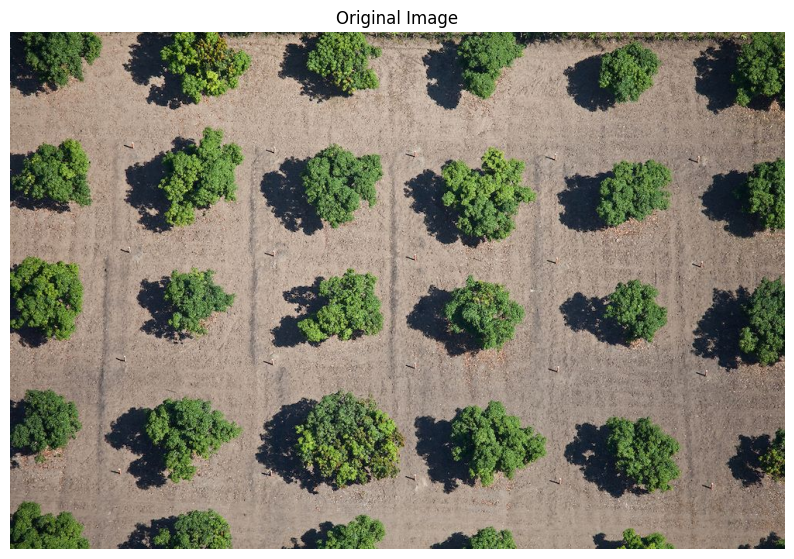

In [8]:
from plant_search.load_image import load_image, plot_image

# file_path = '../input/ESPG-4326-orthophoto.tif'
# file_path = '../input/MADRID_RGB.tif'
file_path = '../input/aerial-trees.jpg'

image = load_image(file_path)
if image is not None:
    plot_image(image, "Original Image")


## Image Preprocessing

### LAB Image Color Space

Expected Results:

- **L**: A grayscale image showing brightness across the image.
- **A**: Red-dominated areas should appear positive (bright), while green-dominated areas should appear negative (dark).
- **B**: Highlights blue-to-yellow dominance.

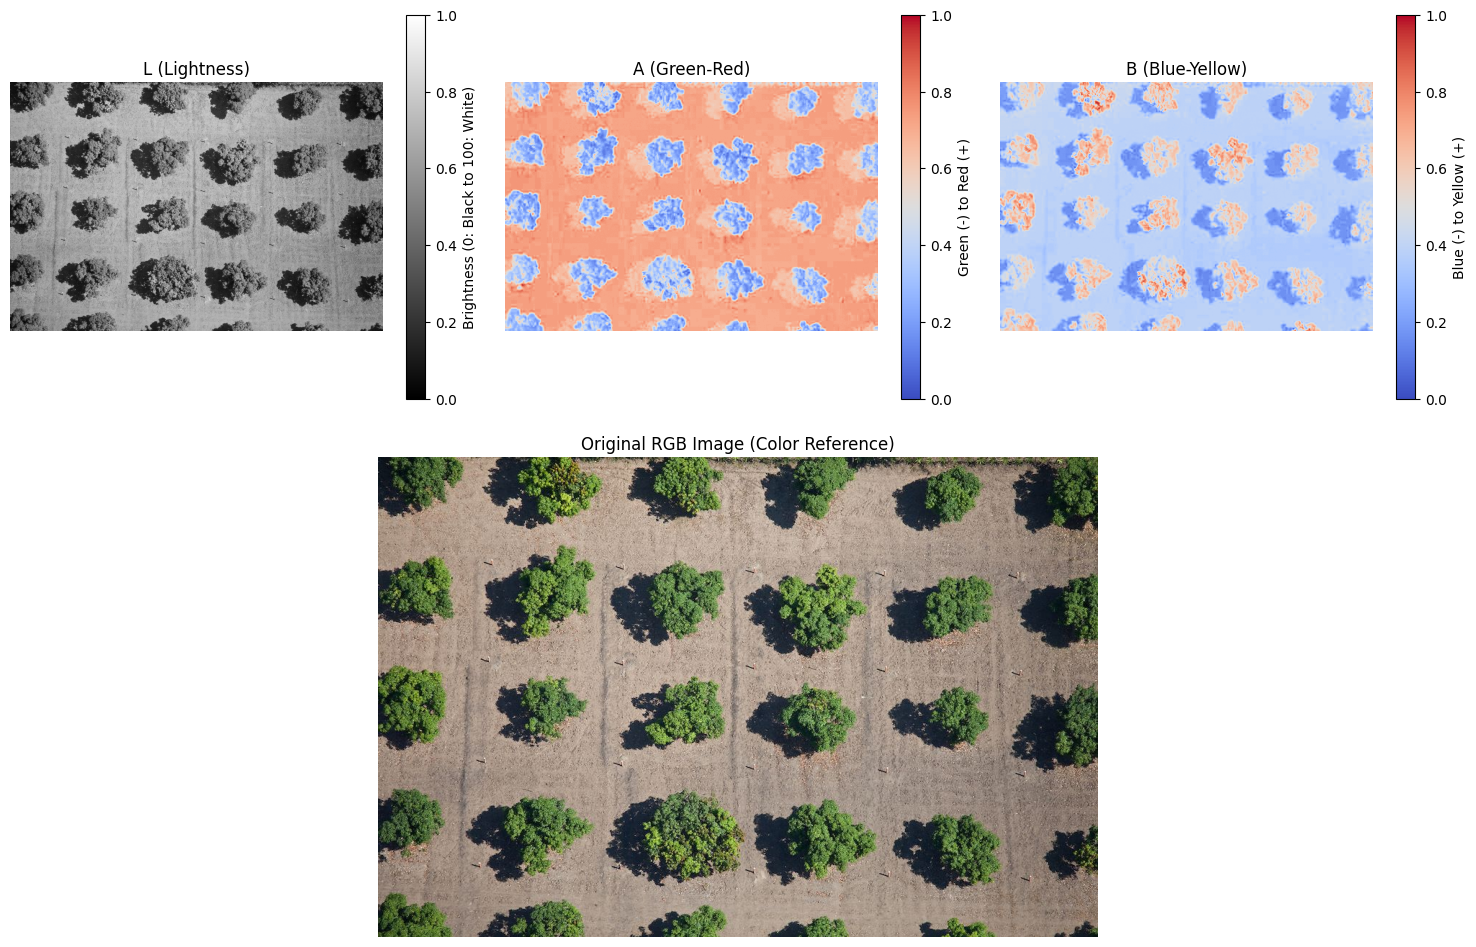

In [9]:
lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
L, A, B = cv2.split(lab_image)

# Set up the grid layout using gridspec
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, height_ratios=[1, 1])  # Equal height for both rows

# First Row: LAB Channels
# L (Lightness)
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(L, cmap='gray')
ax1.set_title("L (Lightness)")
ax1.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=ax1, shrink=0.8)
cbar.set_label("Brightness (0: Black to 100: White)")

# A (Green-Red)
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(A, cmap='coolwarm')
ax2.set_title("A (Green-Red)")
ax2.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="coolwarm"), ax=ax2, shrink=0.8)
cbar.set_label("Green (-) to Red (+)")

# B (Blue-Yellow)
ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(B, cmap='coolwarm')
ax3.set_title("B (Blue-Yellow)")
ax3.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="coolwarm"), ax=ax3, shrink=0.8)
cbar.set_label("Blue (-) to Yellow (+)")

# Second Row: Original Image in Color
ax4 = fig.add_subplot(gs[1, :])  # Span all columns in the second row
ax4.imshow(image)
ax4.set_title("Original RGB Image (Color Reference)")
ax4.axis("off")

plt.tight_layout()
plt.show()

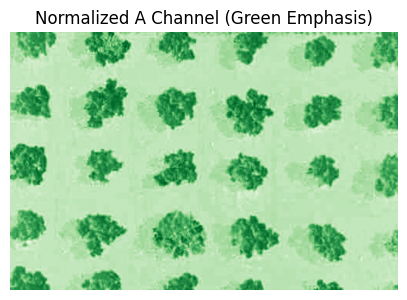

In [10]:
# Normalize the green-dominant range in the A channel
A_normalized = -A  # Flip to make green positive
A_normalized = (A_normalized - A_normalized.min()) / (A_normalized.max() - A_normalized.min())
# A_normalized = -A  # Flip to make green positive

# Visualize normalized green emphasis
plt.figure(figsize=(5, 4))
plt.imshow(A_normalized, cmap='Greens')
plt.title("Normalized A Channel (Green Emphasis)")
plt.axis("off")
plt.show()


### Vegetation Indices

- **ExG:** Excess Green Index 
- **GLI:** Green Leaf Index
- **NDI:** Normalized Difference Index
    - Also referred to as **GRVI** (Green-Red Vegetation Index)
    - Highlights areas with strong green dominance over red.
    - Can be useful for identifying chlorophyll content.
- **VARI:** Visible Atmospherically Resistant Index
- **TVI:** Triangular Vegetation Index
    - Captures vegetation vigor through its triangular relationship.
    - Especially useful for robust vegetation assessments.

In [ ]:
from plant_search.vegetation_indices import calculate_all_indices

# Calculate all indices
indices = calculate_all_indices(image)

# Prepare the indices and titles for plotting
index_titles = [
    ("Excess Green Index (ExG)", indices["ExG"]),
    ("Green Leaf Index (GLI)", indices["GLI"]),
    ("Normalized Difference Index (NDI)", indices["NDI"]),
    ("Visible Atmospherically Resistant Index (VARI)", indices["VARI"]),
    ("Triangular Vegetation Index (TVI)", indices["TVI"]),
]

# Set up the grid for three columns
n_cols = 3
n_rows = (len(index_titles) + n_cols - 1) // n_cols  # Compute rows based on the number of indices
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))

# Plot each index
for i, (title, index) in enumerate(index_titles):
    row, col = divmod(i, n_cols)
    axes[row, col].imshow(index, cmap='Greens')
    axes[row, col].set_title(title)
    axes[row, col].axis("off")

# Turn off unused subplots
for i in range(len(index_titles), n_rows * n_cols):
    row, col = divmod(i, n_cols)
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()


KeyError: 'GRVI'

### Histogram-Based Thresholding

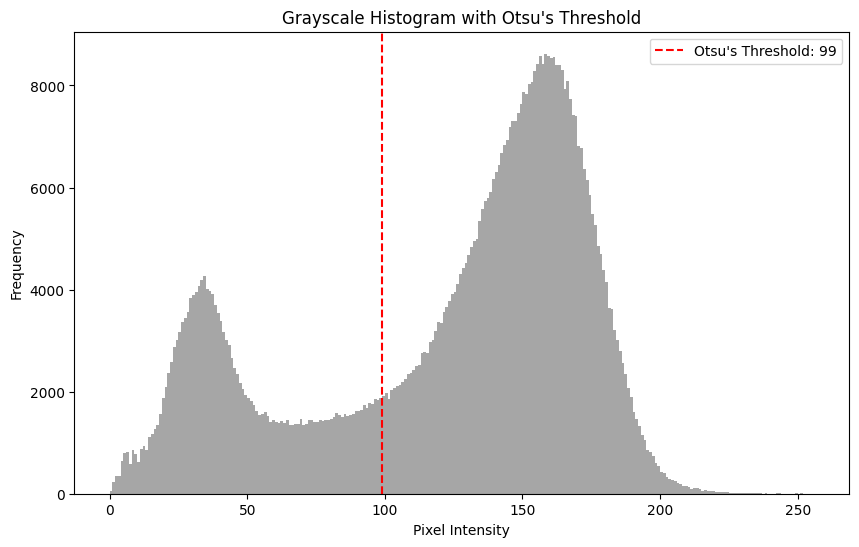

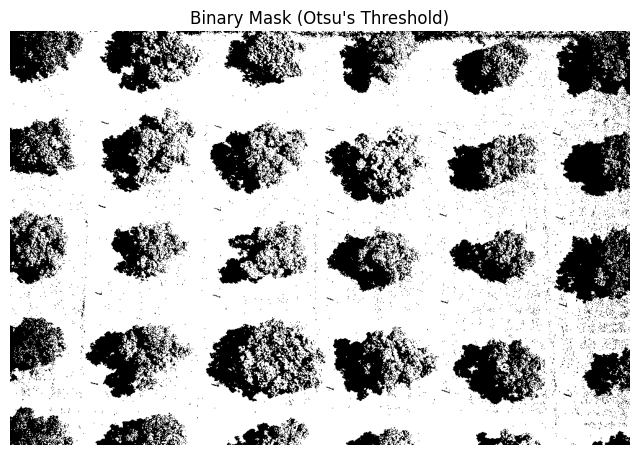

In [12]:
# Convert the RGB image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Otsu's Method
otsu_threshold = threshold_otsu(gray_image)
binary_mask_otsu = gray_image > otsu_threshold

# Visualize the histogram and Otsu's threshold
plt.figure(figsize=(10, 6))
plt.hist(gray_image.ravel(), bins=256, range=(0, 256), color='gray', alpha=0.7)
plt.axvline(otsu_threshold, color='red', linestyle='--', label=f"Otsu's Threshold: {otsu_threshold}")
plt.title("Grayscale Histogram with Otsu's Threshold")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Visualize the binary mask
plt.figure(figsize=(8, 6))
plt.imshow(binary_mask_otsu, cmap='gray')
plt.title("Binary Mask (Otsu's Threshold)")
plt.axis("off")
plt.show()